## Julia on Colaboratory ##

In this code, our capsnet model is trained on enlarged Mnist data,
than this trained weights are tested with affnist_test data for showing capsnet is robust to small affine transformations.

** First two cells are used for google colab


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# Installation cell
%%shell
if ! command -v julia 2>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.3/julia-1.3.1-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add Plots; add PyPlot; add IJulia; add Knet; add MAT;"'
julia -e 'using Pkg; pkg"build Knet;"'

--2020-04-28 17:17:40--  https://julialang-s3.julialang.org/bin/linux/x64/1.3/julia-1.3.1-linux-x86_64.tar.gz
Resolving julialang-s3.julialang.org (julialang-s3.julialang.org)... 151.101.2.49, 151.101.66.49, 151.101.130.49, ...
Connecting to julialang-s3.julialang.org (julialang-s3.julialang.org)|151.101.2.49|:443... connected.
HTTP request sent, awaiting response... 302 gce internal redirect trigger
Location: https://storage.googleapis.com/julialang2/bin/linux/x64/1.3/julia-1.3.1-linux-x86_64.tar.gz [following]
--2020-04-28 17:17:40--  https://storage.googleapis.com/julialang2/bin/linux/x64/1.3/julia-1.3.1-linux-x86_64.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 2607:f8b0:400c:c0d::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95929584 (91M) [application/x-gzip]
Saving to: ‘/tmp/julia.tar.gz’

/tmp/julia.tar.gz   100%[===================

In [1]:
using Knet
# Test if Knet is using gpu
Knet.gpu()

┌ Info: Precompiling Knet [1902f260-5fb4-5aff-8c31-6271790ab950]
└ @ Base loading.jl:1273


0

In [2]:
# Setup display width, load packages, import symbols
ENV["COLUMNS"]=72
using Pkg; for p in
 ("Knet","IterTools","Plots"); haskey(Pkg.installed(),p) || Pkg.add(p); end

using Base.Iterators: flatten
using IterTools: ncycle, takenth
using Statistics: mean
using Knet: Knet, conv4, pool, mat, KnetArray, nll, zeroone, progress, sgd, param, param0, dropout, relu, Data, gpu
using PyPlot
using Plots
using MAT
IJulia.set_max_stdio(1<<25);

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
 Installed IterTools ─ v1.3.0
  Updating `~/.julia/environments/v1.3/Project.toml`
  [c8e1da08] + IterTools v1.3.0
  Updating `~/.julia/environments/v1.3/Manifest.toml`
  [c8e1da08] + IterTools v1.3.0


┌ Info: Precompiling IterTools [c8e1da08-722c-5040-9ed9-7db0dc04731e]
└ @ Base loading.jl:1273
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1273
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273
┌ Info: Precompiling MAT [23992714-dd62-5051-b70f-ba57cb901cac]
└ @ Base loading.jl:1273


In [ ]:
include(Knet.dir("data","mnist.jl"))  # Load data
  

In [135]:
use_reconstruction_loss = true
number_of_iteration = 3;
number_of_epochs = 10;
conv_layer_channel_number = 256
dimension_of_PrimaryCaps_vector = 8
number_of_PrimaryCaps = 8*8*32
height_width_of_PrimaryCaps = 8
number_of_class = 10
dimension_of_DigitCaps = 16
first_conv_layer_size = 13
first_conv_layer_stride = 1
second_conv_layer_size = 13
second_conv_layer_stride = 2

2

In [ ]:
get_files_from_drive = false; # I used it for using with colab and google drive
use_reconstruction_loss = true #  Saved datas only availabl true on mnist enlarged
number_of_iteration = 3;  # Saved datas only available for 3. Any integer more than 1 can be selected but training from scratch will be required.
number_of_epochs = 10;

In [ ]:
# Initializing parameters

batch_size = 50;
height_width_of_Image = 40
conv_layer_channel_number = 256
dimension_of_PrimaryCaps_vector = 8
number_of_PrimaryCaps = 8*8*32
height_width_of_PrimaryCaps = 8
number_of_class = 10
dimension_of_DigitCaps = 16
total_size_of_Digitcaps = dimension_of_DigitCaps*number_of_class;
first_conv_layer_size = 13
first_conv_layer_stride = 1
second_conv_layer_size = 13
second_conv_layer_stride = 2
decoder_dense_layer_1_size = 1024
decoder_dense_layer_2_size = 2048
decoder_dense_layer_3_size = height_width_of_Image*height_width_of_Image;
#Parameters used in margin loss function
m_plus = 0.9;
m_minus = 0.1;
lambda = 0.5;
r_loss = 0.0005;

In [82]:

function batch_visualization(x,width)
c = mat(x)
image_knet_array = convert(KnetArray{Float64,2},zeros(width*10,width*5));
for i = 1: 10
  for j = 1: 5
    image_knet_array[(i-1)*width+1:(i*width),(j-1)*width+1:(j*width)]  = convert(Array{Float64},reshape(c[:,(i-1)*5+j]',(width,width)));
  end
end
full_image = convert(Array{Float64,2},image_knet_array');
imshow(full_image, cmap="gray")
axis("off");
end



batch_visualization (generic function with 1 method)

In [83]:
function minibatch_custom(X, Y, bs=50)
    #takes raw input (X) and gold labels (Y)
    #returns list of minibatches (x, y)
    data = Any[]
    for i = 1 : bs : size(X,4)
        push!(data,(X[:,:,:,i:i+bs-1],Y[i:i+bs-1]))
    end
    return data                                                                 
end 

minibatch_custom (generic function with 2 methods)

In [84]:
 function create_enlarged_mnist_batches()
  xtrn, ytrn, xtst, ytst = mnist() # loading the data
  xtrn = reshape(xtrn, 784, 60000)
  xtst = reshape(xtst, 784, 10000)
  a = reshape(xtrn,28,28,60000)
  b = reshape(xtst,28,28,10000)
  affine_xtrn = zeros(40,40,60000)
  affine_xtst = zeros(40,40,10000)
  for i = 1 : 60000
    x_shift = Int(ceil(rand()*20))
    y_shift = Int(ceil(rand()*20))
    affine_xtrn[x_shift:x_shift+19,y_shift:y_shift+19,i] = a[5:24,5:24,i]
  end

  for i = 1 : 10000
    x_shift = Int(ceil(rand()*20))
    y_shift = Int(ceil(rand()*20))
    affine_xtst[x_shift:x_shift+19,y_shift:y_shift+19,i] = b[5:24,5:24,i]
  end

  affine_xtrn = reshape(affine_xtrn,(40,40,1,60000))
  affine_xtrn = convert(KnetArray{Float32},affine_xtrn)

  affine_xtst = reshape(affine_xtst,(40,40,1,10000))
  affine_xtst = convert(KnetArray{Float32},affine_xtst)
  dtrn = minibatch_custom(affine_xtrn,ytrn)
  dtst = minibatch_custom(affine_xtst,ytst)
  return dtrn , dtst
end

create_enlarged_mnist_batches (generic function with 1 method)

In [ ]:
dtrn,dtst = create_enlarged_mnist_batches();

In [86]:
# Squashing function definition
function squashing(s; axis=2)
  norm2 = sum(abs2.(s),dims=axis);
  scaled = s./sqrt.(norm2);
  result = (norm2./(norm2.+1)).*scaled;
end

squashing (generic function with 1 method)

In [87]:
#Defining masking function with returns only one column for correct prediction in digit caps
function masking(v,yh)
  expander = convert(KnetArray{Float32},ones(10,50,16));
  masker = permutedims(yh.*expander,(1,3,2));
  masked = v.*masker;
end

masking (generic function with 1 method)

In [88]:
 # 1D array to one hot vector function or if input is 2D with probabilities it gives one hot vector
 function to_onehot(y;target_type = KnetArray{Float32} ,num_class = 10)
  if length(size(y)) == 1 
          length_y = length(y)
          onehot = convert(target_type,zeros(num_class, length_y))
          for i = 1 : length_y
            onehot[y[i],i]=1;
          end
          result = onehot
    elseif length(size(y)) == 2
          num_class = size(y,1)
          length_y= size(y,2)  
          onehot = convert(target_type,zeros(num_class, length_y))
          maxes = maximum(y, dims = 1)
          for j=1:length_y
              for i=1:num_class
                  if maxes[j]==y[i,j]
                  onehot[i,j] = 1
                  end
             end
          end
          result = onehot
    end
  return result
  end

to_onehot (generic function with 1 method)

In [89]:
# Calculating loss and error on data set with using W array 
function calculate_loss_and_error(trained_ws,data,model;numIter=3)
  l_ws = length(trained_ws)
  error_in_epochs = Float64[]
  loss_in_epochs = Float64[]

  for i = 1:l_ws
    current_w = trained_ws[i];
    loss_network_current_weight = loss_network(current_w,data,model;withReconstruct = false,numIter=numIter);
    accuracy_error_current_weight = error_in_data(current_w,data,model;numIter=numIter);
    push!(error_in_epochs,accuracy_error_current_weight)
    push!(loss_in_epochs,loss_network_current_weight)
  end
  return error_in_epochs, loss_in_epochs
end

# Showing result functions
function show_results(train_err,train_loss,test_err,test_loss)
  all_results = Any[];
  push!(all_results,train_err)
  push!(all_results,train_loss)
  push!(all_results,test_err)
  push!(all_results,test_loss)

  x_datas = 1:length(train_err);
  PyPlot.plot(x_datas,train_err)
  PyPlot.plot(x_datas,test_err)
  PyPlot.legend(["Train","Test"])
  PyPlot.ylabel("Accuracy Error")
  PyPlot.xlabel("Epochs")
  PyPlot.title("Accuracy Error Comparison")
  PyPlot.figure()
  PyPlot.plot(x_datas,train_loss)
  PyPlot.plot(x_datas,test_loss)
  PyPlot.legend(["Train","Test"])
  PyPlot.ylabel("Loss Error")
  PyPlot.xlabel("Epochs")
  PyPlot.title("Loss Comparison")
  return all_results;
end

function show_error_on_affnist(test_err)  
  x_datas = 1:length(test_err);
  PyPlot.plot(x_datas,test_err)
  PyPlot.legend(["Test"])
  PyPlot.ylabel("Accuracy Error")
  PyPlot.title("Accuracy Error Tested on Affnist")
  PyPlot.xlabel("Epochs")
end


function show_results(test_err,test_loss)
  all_results = Any[];
  push!(all_results,test_err)
  push!(all_results,test_loss)
  x_datas = 1:length(test_err);
  PyPlot.plot(x_datas,test_err)
  PyPlot.legend(["Test"])
  PyPlot.ylabel("Accuracy Error")
  PyPlot.xlabel("Epochs")
  PyPlot.title("Accuracy Error")
  PyPlot.figure()
  PyPlot.plot(x_datas,test_loss)
  PyPlot.legend(["Test"])
  PyPlot.ylabel("Loss Error")
  PyPlot.xlabel("Epochs")
  PyPlot.title("Loss")
  return all_results;
end

function show_results(results)
  if length(results) == 2
    show_results(results[1],results[2])
  elseif length(results) == 4
    show_results(results[1],results[2],results[3],results[4])
  end
end

#Function for getting file name dependent on variables 
function getFileName(type = "w" ; fromDrive = false)
if fromDrive
  loc = "/content/gdrive/My Drive/Comp541-Datas/final_weight_upload/capsnet_trained_on_enlarged_mnist_"*type*".jld2";
else
  loc = pwd()*"/Datas/capsnet_trained_on_enlarged_mnist_"*type*".jld2"
end
  return loc
end

getFileName (generic function with 4 methods)

In [90]:
# Creates convolution layer for network
function convolution_layer(w, x)
    x = relu.(conv4(w[1], x, stride = first_conv_layer_stride) .+ w[2])
    x = relu.(conv4(w[3], x, stride = second_conv_layer_stride) .+ w[4])
    return x
end

convolution_layer (generic function with 1 method)

In [119]:
# Creates capsule layer for network
function caps_layer(w,x,numIter)
x = reshape(x,(height_width_of_PrimaryCaps,height_width_of_PrimaryCaps,dimension_of_PrimaryCaps_vector,32,batch_size));
x = permutedims(x,(1,2,4,3,5));
x = reshape(x,(number_of_PrimaryCaps,dimension_of_PrimaryCaps_vector,1,1,batch_size));
w_expander = convert(KnetArray{Float32},ones(size(w,1),size(w,2),size(w,3),size(w,4),batch_size));
w_expanded = w_expander.*w;

u_hat = sum(w_expanded.*x,dims=2);
u_hat = reshape(u_hat,(number_of_PrimaryCaps,number_of_class,dimension_of_DigitCaps,batch_size));

b = convert(KnetArray{Float32},zeros(size(w,1),size(w,3),1,batch_size));
for i = 1 :(numIter)
    c = softmax(b,dims=2);
    s = permutedims(reshape(sum((c.*u_hat),dims=1),dimension_of_DigitCaps,number_of_class,batch_size),(2,1,3));
    v = squashing(s);
    v = reshape(v,(1,number_of_class,dimension_of_DigitCaps,batch_size));
    aggrement = sum(u_hat.*v,dims = 3);
    b = b.+aggrement;
end;

v= reshape(v,(number_of_class,dimension_of_DigitCaps,batch_size));
prob = sqrt.(sum(abs2.(v),dims=2));
prob = reshape(prob,number_of_class,batch_size);
return prob, v

end

caps_layer (generic function with 1 method)

In [120]:
# Creates decoder layer for network which is using in reconstruction
function decoder_layer(w,v)  
    v = relu.(w[1]*mat(v).+w[2]);
    v = relu.(w[3]*mat(v).+w[4]);
    v = sigm.(w[5]*mat(v).+ w[6]);
    return v
end

decoder_layer (generic function with 1 method)

In [121]:
# Creates full layer for network(Decoder layer is only used when reconstruction error is used )
function complete_network(w,x,numIter)
  x = convolution_layer(w[1:4],x);
  return caps_layer(w[5],x,numIter)
end

complete_network (generic function with 1 method)

In [122]:
#Initializin W for network
function initialize_W(withReconstruct)
    wts = Any[ convert(KnetArray{Float32},xavier(first_conv_layer_size,first_conv_layer_size,1,conv_layer_channel_number)),  convert(KnetArray{Float32},zeros(1,1,conv_layer_channel_number,1)), 
        convert(KnetArray{Float32},xavier(second_conv_layer_size,second_conv_layer_size,conv_layer_channel_number,conv_layer_channel_number)), convert(KnetArray{Float32},zeros(1,1,conv_layer_channel_number,1))]
    W = convert(KnetArray{Float32},xavier(number_of_PrimaryCaps,dimension_of_PrimaryCaps_vector,number_of_class,dimension_of_DigitCaps))
    push!(wts,W)
    if withReconstruct
      push!(wts,convert(KnetArray{Float32},xavier(decoder_dense_layer_1_size,total_size_of_Digitcaps)))
      push!(wts,convert(KnetArray{Float32},zeros(decoder_dense_layer_1_size,1)))
      push!(wts,convert(KnetArray{Float32},xavier(decoder_dense_layer_2_size,decoder_dense_layer_1_size)))
      push!(wts,convert(KnetArray{Float32},zeros(decoder_dense_layer_2_size,1)))
      push!(wts,convert(KnetArray{Float32},xavier(decoder_dense_layer_3_size,decoder_dense_layer_2_size)))
      push!(wts,convert(KnetArray{Float32},zeros(decoder_dense_layer_3_size,1)))
    end
    return wts
end

initialize_W (generic function with 1 method)

In [123]:
# Calculating loss of network
function loss_network(w,x, y, model;withReconstruct = false,numIter = 1)
    yprob, v = model(w[1:5],x,numIter);
    T = to_onehot(y);
    margin_loss = sum((T.*abs2.(relu.(m_plus.-yprob)))+lambda.*(1 .-T).*(abs2.(relu.(yprob.-m_minus))));
    reconstruction_loss = 0;
    if withReconstruct
      masked_v = masking(v,T);
      decoded_res = decoder_layer(w[6:11],masked_v) ;
      reconstruction_loss = sum(abs2.(mat(x).-decoded_res)) 
    end
    loss = margin_loss+reconstruction_loss*r_loss
end
# Calculating loss of network in dataset
loss_network(w,data,model;withReconstruct,numIter) = mean(loss_network(w,x,y,model;withReconstruct = withReconstruct,numIter=numIter) for (x,y) in data)
# Grad loss network is defined for using in training
grad_loss_network = grad(loss_network)


(::AutoGrad.var"#gradfun#7"{AutoGrad.var"#gradfun#6#8"{typeof(loss_network),Int64,Bool}}) (generic function with 1 method)

In [124]:
function train_full_capsnet(w,data,model;withReconstruct=false,numIter=1,numberOfEpochs=5)
    current_batch_no= 0;
    total_batch_number = numberOfEpochs*length(data)
    weights_for_epochs = Any[]
    opts = map(x->Adam(), w) 
    for i in 1:numberOfEpochs
        for (x,y) in data
            g = grad_loss_network(w,x,y,model;withReconstruct=withReconstruct,numIter=numIter)
            update!(w,g,opts)
            Main.IJulia.clear_output(true)
            current_batch_no = current_batch_no+1;
            print("\n  " *string(current_batch_no)* " . Total number of batches is = " * string(total_batch_number))
        end
        push!(weights_for_epochs,deepcopy(w))
    end
    return weights_for_epochs
end

train_full_capsnet (generic function with 1 method)

In [ ]:
#Finding accuracy function for one batch
function accurate(w,x,y_gold,model;numIter=1)
    yprb, v = model(w,x,numIter)
    y_prediction = to_onehot(yprb ; target_type = Array{Int8})
    num_correct = 0;
    num_total = length(y_gold);
        for j = 1 : num_total
      if y_gold[j] == 0
        y_gold[j] =10
        end
        end
    for i = 1 : num_total
      num_correct += (y_prediction[y_gold[i],i]==1) ? 1.0 : 0.0
    end
    return num_correct/num_total
end

#Finding accuracy function for whole data
function accurate(w,data,model;numIter=1)
  current_batch_no = 0
  sum_total = 0;
  total= length(data)
  for (x,y) in data
    current_batch_no = current_batch_no+1;
    sum_total += accurate(w,x,y,model;numIter=numIter);
    Main.IJulia.clear_output(true);
    print("\n Current batch number is  " *string(current_batch_no)* "th with current total correct probability " * string(sum_total/current_batch_no)* ". Total number of batches is = " * string(total))
  end
  return sum_total/current_batch_no;
end

#Finding error function for whole data
function error_in_data(w,data,model;numIter=1)
  error_in_prediction = 1 - accurate(w,data,model;numIter=numIter)
end


In [ ]:
if (print("Train from scratch? "); readline()[1]=='y')
  w_init = initialize_W(use_reconstruction_loss);
  trained_weights = train_full_capsnet(w_init,dtrn,complete_network;withReconstruct = use_reconstruction_loss,numIter=number_of_iteration,numberOfEpochs=number_of_epochs);
  w_trained = deepcopy(w_init)
else
  w_trained_file_name = getFileName("w",fromDrive = get_files_from_drive);
  w_trained = Knet.load(w_trained_file_name,"weight");
end

In [ ]:
## This cell calculates error of trained W on enlarged MNist Data set
err_tst_w = error_in_data(w_trained,dtst,complete_network, numIter=number_of_iteration)
println("Total error on test data is "*string(err_tst_w));

Show results from scratch?(For showing results from scratch you should train from scratch first!) stdin> n


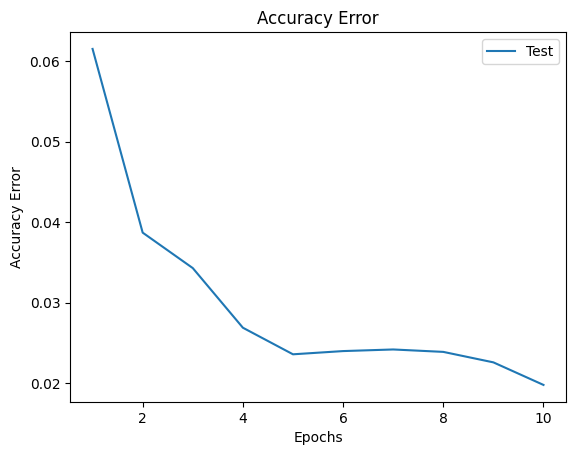

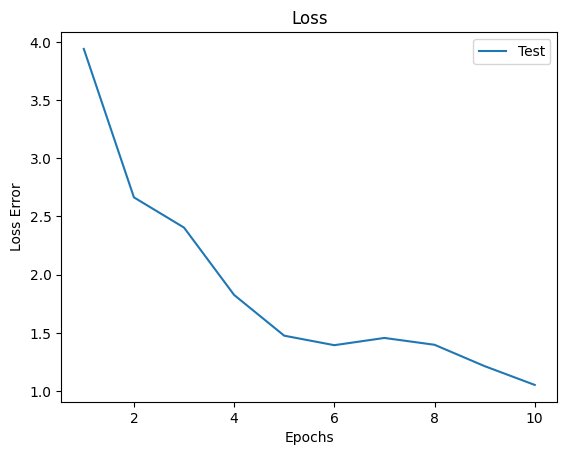

2-element Array{Any,1}:
 [0.06150000000000044, 0.03870000000000118, 0.034300000000000774, 0.026900000000001256, 0.02360000000000073, 0.0240000000000008, 0.02420000000000111, 0.023900000000001143, 0.022600000000001064, 0.019800000000000373]
 [3.9389157819747926, 2.663874010145664, 2.4043396431207658, 1.8257644063234328, 1.475851137638092, 1.3943122240155936, 1.4564651837944984, 1.3977860484272242, 1.2142532961815595, 1.0529979894310235]                

In [71]:
if (print("Show results from scratch?(For showing results from scratch you should train from scratch first!) "); readline()[1]=='y')
  tst_err,tst_loss = calculate_loss_and_error(trained_weights,dtst,complete_network;numIter=number_of_iteration)
  #trn_err,trn_loss = calculate_loss_and_error(trained_weights,dtrn,complete_network;numIter=number_of_iteration)
  all_results = show_results(tst_err,tst_loss);
else
  results_file_name = getFileName("results",fromDrive = get_files_from_drive);
  all_results = Knet.load(results_file_name,"results");
  show_results(all_results); 
end

In [74]:
## Function for creating batched affnist test data in KnetArray32 format from mat file
function affnist_test_data_batched()
  file_loc = pwd()*"/Datas/Affnist_test_mat_type/1.mat";
  test_datas_raw = matread(file_loc)
  xtstraw = test_datas_raw["affNISTdata"]["image"];
  ytst = test_datas_raw["affNISTdata"]["label_int"];
  affine_xtst = reshape(xtstraw,(40,40,1,10000))
  affine_xtst = convert(KnetArray{Float32},affine_xtst)
  for i = 1 : length(ytst)
    if ytst[i] == 0
      ytst[i] = 10;
    end
  end
  ytst = convert(Array{UInt8},reshape(ytst,(10000)))
  dtst = minibatch_custom(affine_xtst, ytst);
  return dtst
end

affnist_test_data_batched (generic function with 1 method)

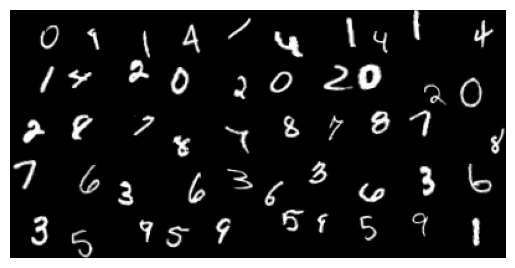

(-0.5, 399.5, 199.5, -0.5)

In [75]:
## This cell is for clarifying 
dtst_affnist = affnist_test_data_batched()
x,y = first(dtst_affnist)
batch_visualization(x,40)

In [76]:
## This cell calculates error on affnist dataset
## Our model is trained on expanded MNist and never trained on Affnist data set

err_tst_w = error_in_data(w_trained,dtst_affnist,complete_network, numIter=number_of_iteration)
println("Total error on test data is "*string(err_tst_w));


 Current batch number is  200th with current total correct probability 0.7338000000000002. Total number of batches is = 200Total error on test data is 0.26619999999999977


In [ ]:
file_name = pwd()*"/Datas/capsnet_trained_on_enlarged_mnist_tested_on_affnist_error.jld2"
error_on_affnist = Knet.load(file_name,"error")
show_error_on_affnist(error_on_affnist)